In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_dyn
import ELPH_utils


#global hyperparameters
kmax = 4.
n_kmax = 80


# init = ELPH_dyn.get_init_cond_gauss(kmax = kmax, n_kmax = n_kmax, max_pos = 0.15, width = 0.05, density=density)
# plt.plot(init[:n_kmax])
# plt.show()

# nkdyn = ELPH_dyn.get_el_dynamics(init, n_kmax = n_kmax)
# plt.imshow(nkdyn, aspect='auto')
# plt.colorbar()
# plt.show()

In [39]:
n_runs = 100

paras = np.zeros((n_runs,3))

paras[:,0] = np.linspace(0.1,0.7,n_runs) #max_pos
paras[:,1] = 0.05 #width
paras[:,2] = 0.1 #density

runs = ELPH_utils.get_runs_gaussian_init(kmax, n_kmax, paras, tmax=1000, n_tmax=200)


run  1  from  100
run  2  from  100
run  3  from  100
run  4  from  100
run  5  from  100
run  6  from  100
run  7  from  100
run  8  from  100
run  9  from  100
run  10  from  100
run  11  from  100
run  12  from  100
run  13  from  100
run  14  from  100
run  15  from  100
run  16  from  100
run  17  from  100
run  18  from  100
run  19  from  100
run  20  from  100
run  21  from  100
run  22  from  100
run  23  from  100
run  24  from  100
run  25  from  100
run  26  from  100
run  27  from  100
run  28  from  100
run  29  from  100
run  30  from  100
run  31  from  100
run  32  from  100
run  33  from  100
run  34  from  100
run  35  from  100
run  36  from  100
run  37  from  100
run  38  from  100
run  39  from  100
run  40  from  100
run  41  from  100
run  42  from  100
run  43  from  100
run  44  from  100
run  45  from  100
run  46  from  100
run  47  from  100
run  48  from  100
run  49  from  100
run  50  from  100
run  51  from  100
run  52  from  100
run  53  from  100
ru

runs[0] shape:  (80, 200)


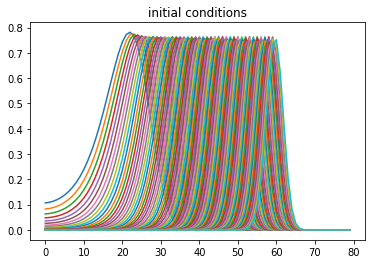

In [40]:
# plt.imshow(runs[1], aspect='auto')
# plt.colorbar()
# plt.show()

print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()

In [41]:
from ELPH_VAR import SVDVAR
    
VAR = SVDVAR(runs, rdim=10, n_VAR_steps=5)

VAR.train(alpha=10**-2.7, rdim = 20, n_VAR_steps = 20, method='ridge')

VAR.print_status()


rdim:  20
n_VAR_steps:  20
state shape:  (400, 18000)
target shape:  (20, 18000)
weights shape:  (400, 20)


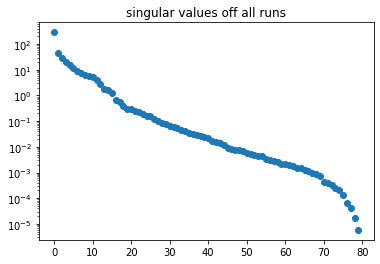

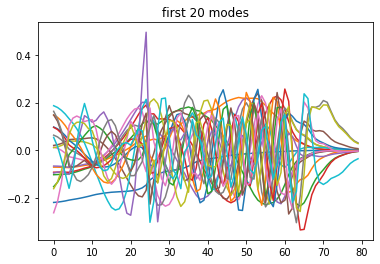

In [43]:
plt.semilogy(VAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(VAR.rdim):
  plt.plot(VAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(VAR.rdim) + ' modes')
plt.show()

0.06044356586243029


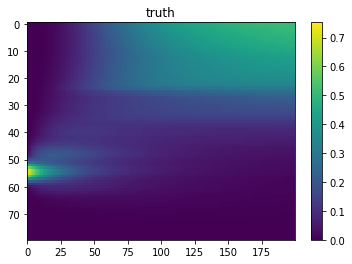

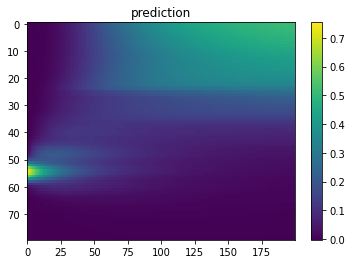

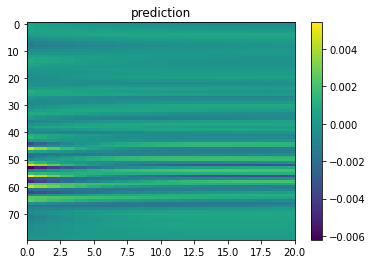

In [46]:

run = runs[80]
testpred = VAR.predict_single_run(run)

print(VAR.get_error(run, norm='fro') )

plt.imshow(run, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('truth')
plt.show()

plt.imshow(testpred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('prediction')
plt.show()

plt.imshow(run-testpred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,20)
plt.show()

In [71]:

mean_score, scores = ELPH_utils.get_KFold_CV_scores(VAR, runs, folds=5, seed=817, alpha=10**-2.7, rdim=20, n_VAR_steps=20, norm='fro')

print('mean score: ', mean_score)
print('scores: ', scores)





mean score:  0.07261373643707647
scores:  [0.07214045333631793, 0.0771567411109285, 0.07162497382579577, 0.07405205433029521, 0.06809445958204496]


In [ ]:
def get_BO_score(aExp, rdim, n_VAR_steps):
    alpha = 10.0**aExp
    rdim = int(rdim)
    n_VAR_steps = int(n_VAR_steps)
    
    m,s = ELPH_utils.get_KFold_CV_scores(VAR, runs, folds=5, seed=817, alpha=alpha, rdim=rdim, n_VAR_steps=n_VAR_steps, norm='var2')
    return -1.*m - 1.*np.std(s)


# print(KFCV_score(-6,3,5))

from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'aExp': [-6, -1], 'rdim': [1,20], 'n_VAR_steps': [1,20]}

optimizer = BayesianOptimization(
    f=get_BO_score,
    pbounds=pbounds,
    random_state=816,
)

# optimizer.maximize(init_points=10, n_iter=100)

rdim:  5
n_VAR_steps:  3
NVAR_p:  2
VAR state shape:  (15, 19503)
NVAR state shape:  (135, 19503)
target shape:  (5, 19503)
weights shape:  (135, 5)


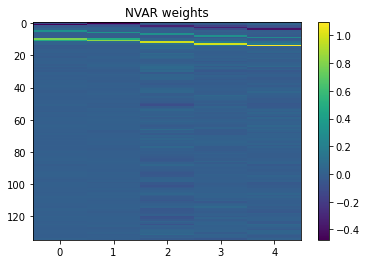

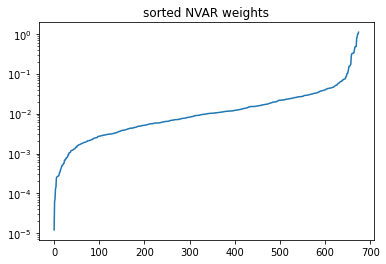

NVAR err:  1.8683589652041837


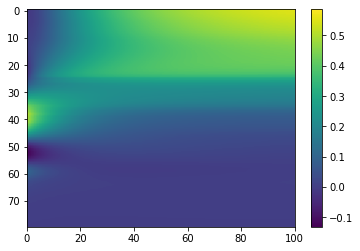

rdim:  5
n_VAR_steps:  3
state shape:  (15, 19503)
target shape:  (5, 19503)
weights shape:  (15, 5)
VAR err:  2.9404418915855133


In [69]:

from ELPH_NVAR import SVDNVAR


ntestrun = 32
train_runs = runs.copy()
test_run = train_runs.pop(ntestrun)

a = 1e-2
r = 5
n = 3


NVAR = SVDNVAR(train_runs)

NVAR.train(alpha=a, rdim=r, n_VAR_steps=n, NVAR_p=2)

NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()


print('NVAR err: ', NVAR.get_error(test_run, norm='fro') )
trNVAR = NVAR.predict_single_run(test_run)

plt.imshow(trNVAR, aspect='auto')
plt.colorbar()
plt.xlim(0,100)
plt.show()


VAR.load_runs(train_runs)
VAR.train(alpha=a, rdim=r, n_VAR_steps=n)

VAR.print_status()
print('VAR err: ', VAR.get_error(test_run, norm='fro') )
trVAR = VAR.predict_single_run(test_run)






rdim:  15
n_VAR_steps:  5
NVAR_p:  2
VAR state shape:  (75, 19305)
NVAR state shape:  (2925, 19305)
target shape:  (15, 19305)
weights shape:  (2925, 15)


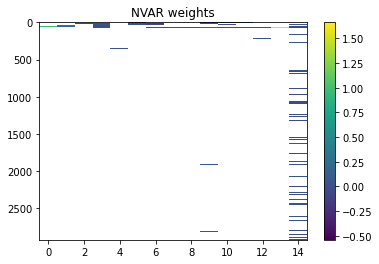

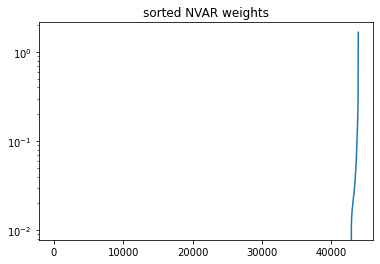

NVAR err:  2.3909435663847125


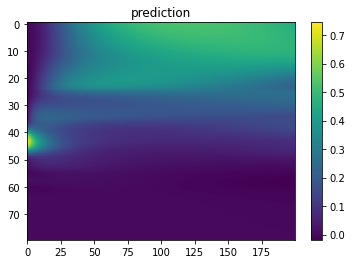

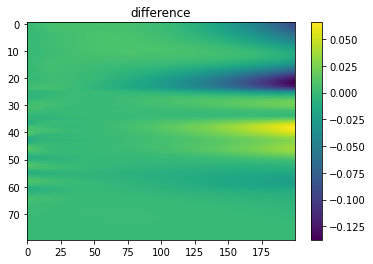

In [84]:
train_runs = runs[::1]
test_run = train_runs.pop(45)

NVAR.load_runs(train_runs)

NVAR.train(rdim=15, n_VAR_steps=5, NVAR_p=2, method='stlsq', alpha=10**-2.7, threshold=0.01)

NVAR.print_status()

masked_weights = np.ma.masked_values(NVAR.w,0.0)

plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()


print('NVAR err: ', NVAR.get_error(test_run, norm='fro') )
preNVAR = NVAR.predict_single_run(test_run)

plt.imshow(preNVAR, aspect='auto')
plt.colorbar()
plt.title('prediction')
# plt.xlim(0,100)
plt.show()

plt.imshow(preNVAR-test_run, aspect='auto')
plt.colorbar()
plt.title('difference')
# plt.xlim(0,100)
plt.show()